In [2]:
!python --version

Python 3.13.5


## 목차

1. 프로젝트 개요  
    1.1. 문제 정의 및 목표  
    1.2. 데이터셋 소개  
    1.3. 평가 지표

2. 환경 설정 및 데이터 준비  
    2.1. 실험 환경 설정  
    2.2. 데이터 로드 및 기본 구조 확인  

3. 데이터 전처리 및 증강  
    3.1. 이미지 전처리  
    3.2. 데이터 증강 기법 적용

4. 모델 구현 및 학습  
    4.1. [모델 1] 기본 CNN 직접 구현  
    4.2. [모델 2] 전이학습 (Feature Extraction)  
    4.3. [모델 3] 전이학습 (Partial Fine-Tuning)  
    4.4. [모델 4] 전이학습 (Full Fine-Tuning)  
    4.5. 추가 실험

5. 모델 평가 및 비교  
    5.1. 실험 조건
    5.2. 평가 지표 산출 절차  
    5.3. 조건별 성능 비교  

6. 결론 및 개선 방향  
    6.1. 결론  
    6.2. 개선 방향  

## 1. 프로젝트 개요

### 1.1. 문제 정의 및 목표

- 흉부 X-ray 이미지를 바탕으로 폐렴 환자와 정상 환자를 구분하는 이미지 분류 모델 개발

- 다양한 신경망 기반 모델 실험(CNN 직접 구현, 전이학습, 파인튜닝 등)을 통해 폐렴 진단 정확도를 향상시키는 것이 목표

### 1.2. 데이터셋 소개

- 출처: Kaggle Chest X-Ray Images (Pneumonia) 데이터셋

- 구성: 5,863개의 흉부 X-ray 이미지(JPEG) 포함, Pneumonia(폐렴)와 Normal(정상) 두 클래스로 구분됨.

- 폴더 구조: train (훈련용), val(검증용), test(테스트용)로 구분 및 각 클래스별 서브폴더

### 1.3. 평가 지표

- 모델 성능 평가는 Accuracy(정확도), Precision(정밀도), Recall(재현율), F1-score를 함께 사용해 각 모델의 예측력을 종합적으로 분석한다.

- 클래스 불균형과 임상적 활용성을 고려해 혼동행렬(Confusion Matrix)도 병렬적으로 제시하며, 세부 지표별 결과를 비교 분석한다.

- 최종 성능 평가는 제공된 테스트셋 기반으로 이루어지며, 노트북 파일에 모델별 평가 지표 결과를 상세하게 기록한다.

</br>

**참고 사항**
- Accuracy: 전체 예측 중 맞게 맞춘 비율, 높을수록 좋음
- Precision (정밀도): 모델이 양성으로 예측한 것 중 실제 양성 비율, 높을수록 좋음
- Recall (재현율): 실제 양성 중 모델이 맞게 예측한 비율, 높을수록 좋음
- F1-score: Precision과 Recall의 조화 평균, 높을수록 좋음

## 2. 환경 및 데이터 준비

### 2.1. 환경 설정

- 로컬 Jupyter Notebook(Python 3.13.5) 환경에서 실습 진행

- 로컬 Windows에서 CUDA 지원 GPU 사용 설정

- **데이터셋 폴더 구조**  
    *ipynb 파일은 루트(MISSION6)에 위치함.


data  
├─test  
│  ├─NORMAL  
│  └─PNEUMONIA  
├─train  
│  ├─NORMAL  
│  └─PNEUMONIA  
└─val  
    ├─NORMAL  
    └─PNEUMONIA
  
- BATH PATH: (상위폴더 생략, 현재 위치)\data  

In [3]:
# 환경 설정 (Imports, Device, Seed)

import os
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import datasets, transforms

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [4]:
# 재현성 확보
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# 디바이스 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# 데이터셋 경로 지정 (루트 상대경로)
BASE_PATH = './data'
train_dir = os.path.join(BASE_PATH, 'train')
val_dir = os.path.join(BASE_PATH, 'val')
test_dir = os.path.join(BASE_PATH, 'test')

# 시각화 기본 설정
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.dpi'] = 110

Using device: cuda


- 주요 딥러닝 실험용 라이브러리(torch, torchvision, numpy 등) 및 데이터 처리, 시각화 도구 불러오기

- 실험 재현성을 위해 랜덤 시드 고정

- 데이터셋 경로 및 기본 폴더 트리 설정

- 흑백(JPEG) X-ray 이미지에 대응할 수 있도록 로딩 및 채널 처리 방법 준비

- 모델 학습 및 평가에 사용할 디바이스(CUDA/CPU) 자동 감지 및 지정

### 2.2. 데이터 로드 및 기본 구조 확인

- 실제 분류 실험에서 사용할 Chest X-ray 이미지 데이터를 폴더별로 불러와 전체 데이터 구조와 파일 분포를 파악한다.

- 데이터셋은 train, val, test 세 가지로 구분되어 있고, 각각 하위에 NORMAL(정상)과 PNEUMONIA(폐렴) 폴더가 존재해 클래스별 이미지를 제공한다.

- 모든 이미지는 다양한 크기의 JPEG 흑백(x-ray) 파일로 구성되어 있다. 파일 개수와 대표 이미지를 확인해 데이터 분포와 품질을 탐색한다.

TRAIN | NORMAL: 1341 images   PNEUMONIA: 3875 images
VAL | NORMAL: 8 images   PNEUMONIA: 8 images
TEST | NORMAL: 234 images   PNEUMONIA: 390 images


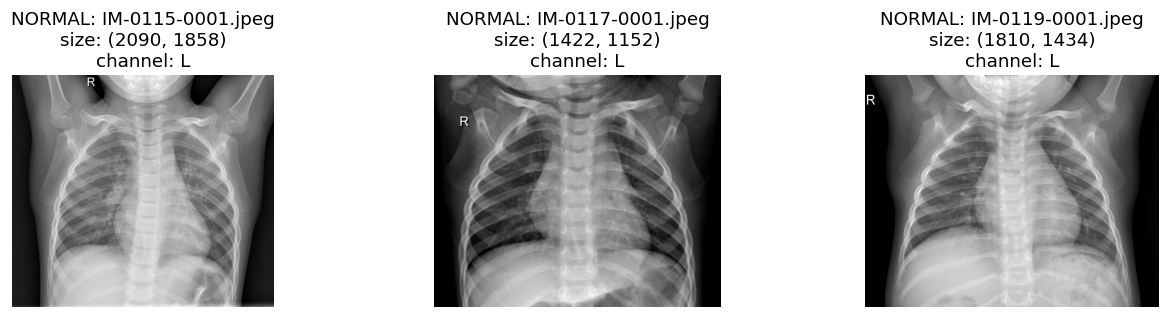

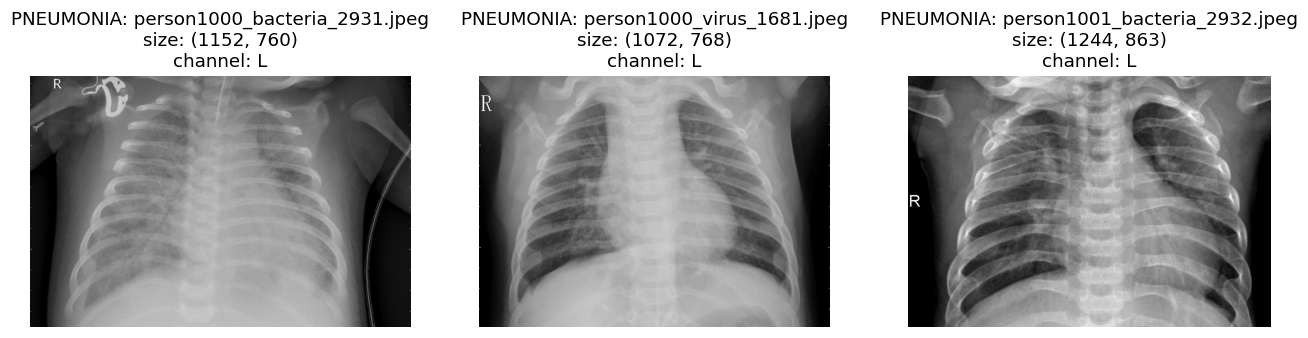

In [5]:
# 2.2 데이터 로드 및 기본 구조 확인

# 클래스별 경로 및 파일수 확인 함수
def get_image_files(split_folder):
    normal_dir = os.path.join(split_folder, 'NORMAL')
    pnm_dir = os.path.join(split_folder, 'PNEUMONIA')
    normal_imgs = sorted(glob(os.path.join(normal_dir, '*.jpeg')))
    pnm_imgs = sorted(glob(os.path.join(pnm_dir, '*.jpeg')))
    return normal_imgs, pnm_imgs

splits = ['train', 'val', 'test']
for split in splits:
    normal_imgs, pnm_imgs = get_image_files(os.path.join(BASE_PATH, split))
    print(f'{split.upper()} | NORMAL: {len(normal_imgs)} images   PNEUMONIA: {len(pnm_imgs)} images')

# 샘플 이미지 확인
def show_sample_imgs(folder, cls_name, num=3):
    img_dir = os.path.join(BASE_PATH, folder, cls_name)
    imgs = sorted(glob(os.path.join(img_dir, '*.jpeg')))
    show_n = min(num, len(imgs))
    if show_n == 0:
        print(f'No images to show in {folder}/{cls_name}')
        return
    plt.figure(figsize=(12, 3))
    for i in range(show_n):
        img = Image.open(imgs[i])
        plt.subplot(1, show_n, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f'{cls_name}: {os.path.basename(imgs[i])}\nsize: {img.size}\nchannel: {img.mode}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# 예시: train/NORMAL 샘플 3개 시각화
show_sample_imgs('train', 'NORMAL')
show_sample_imgs('train', 'PNEUMONIA')

- ```[데이터 분포]``` 전체적으로 폐렴 데이터가 정상 데이터보다 많고, val 데이터 수는 매우 적어 모델 점검/테스트에만 제한적으로 활용함.

- ```[데이터 규격]``` 이미즈 사이즈는 불규칙적이며, 채널은 L(흑백이미지)임.

- ```[샘플 이미지]``` 정상(NORMAL) 샘플: 폐 윤곽과 갈비뼈 구조가 또렷하며 밝음. 전체적으로 명확한 어두움과 선명한 명암 차이 드러남.

- ```[샘플 이미지]``` 폐렴(PNEUMONIA) 샘플: 좌우로 밝게 뿌연 부분이 넓거나 일부에 뚜렷한 혼탁(뿌연 부분)이 보임.  
    *세균성(bacteria)은 밝은 부분이 폐 한쪽에 모여 경계가 비교적 명확하고, 바이러스성(virus)은 전체적으로 흐릿한 영향이 퍼져 경계가 불분명함.

## 3. 데이터 전처리 및 증강

### 3.1. 이미지 전처리

- 다양한 크기의 흑백 X-ray 이미지를 모델 입력에 맞게 통일된 크기로 맞춘다.  
    *비율이 맞지 않는 이미지는 중심을 기준으로 crop 처리(Center crop)를 적용하여 지정한 사이즈로 정렬함.

- 채널 수는 사전에 확인하였으나, 추가적으로 모든 이미지를 그레이스케일(1채널, L 모드)로 변환한다.

- Torchvision의 ```transforms.Normalize```를 사용해 픽셀값을 정규화한다.

### 3.2. 데이터 증강 기법 적용

- 의료 영상 특성을 고려해, 과도한 변형은 피하고 좌우 반전(Horizontal Flip)만 안전하게 적용한다.

- 좌우 반전은 양쪽 폐 구조가 모두 나타나므로 임상적으로 정보 손실이 없고, 데이터 다양성 확보에 효과적이다.

**전처리 및 증강**

In [6]:
# 이미지 전처리 및 증강 transform
IMG_SIZE = 224

train_transform = transforms.Compose([
    # 흑백 강제 통일
    transforms.Grayscale(num_output_channels=1),
    
    # 비율 유지한 리사이즈 후, 패딩
    transforms.Resize(IMG_SIZE),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),  # 흑백 채널: mean, std 1개
    transforms.RandomHorizontalFlip(p=0.5)  # 좌우 반전 증강(학습용만)
])

val_test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(IMG_SIZE),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
    # 검증/테스트셋에는 증강 미적용
])

**데이터셋/데이터로더 정의**

In [7]:
# 데이터셋 정의
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
val_dataset   = datasets.ImageFolder(root=val_dir,   transform=val_test_transform)
test_dataset  = datasets.ImageFolder(root=test_dir,  transform=val_test_transform)

print('Class to idx:', train_dataset.class_to_idx)

Class to idx: {'NORMAL': 0, 'PNEUMONIA': 1}


In [8]:
#데이터로더 정의
BATCH_SIZE = 32
NUM_WORKERS = 2  # 환경에 맞게 조정

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

print(f'train: {len(train_dataset)} | val: {len(val_dataset)} | test: {len(test_dataset)}')

train: 5216 | val: 16 | test: 624


## 4. 모델 구현 및 학습

### 4.1. [모델 1] 기본 CNN 직접 구현

- CNN(Convolutional Neural Network) 모델을 직접 설계하고 구현한다.

- 입력 이미지는 1채널(흑백), 정방형(예: 224x224)으로 맞춰져 출발한다.

- 학습과 검증 루프를 각각분리하고, 이진 분류(폐렴 vs 정상)에 맞춰 마지막 출력층에서 sigmoid 활성함수를 사용한다.

**아키텍처 설계 및 구현**

- Convolutional layer → BatchNorm → ReLU → MaxPooling 블록 반복 사용
- 전역 평균 풀링(AdaptiveAvgPool2d) 후, 완전연결층(Linear)에서 sigmoid로 확률 출력

In [9]:
class BasicCNN(nn.Module):
    def __init__(self):
        super(BasicCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 112x112
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 56x56
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 28x28
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# 모델 인스턴스화
model1 = BasicCNN().to(device)

# 손실함수 및 최적화기 설정
criterion = nn.BCELoss()  # 이진 크로스엔트로피
optimizer = optim.Adam(model1.parameters(), lr=0.001)

**학습 및 검증 루프, 테스트 성능 확인**

- 각 epoch마다 학습/검증을 반복하며, 정확도 및 손실값을 출력한다.

- 검증셋에서는 증강 없이 전처리 후 평가 진행

In [9]:
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for imgs, labels in loader:
        imgs = imgs.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * imgs.size(0)
        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
        total += imgs.size(0)

    epoch_loss = total_loss / max(total, 1)
    epoch_acc = correct / max(total, 1)
    return epoch_loss, epoch_acc


def validate(model, loader, criterion):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            outputs = model(imgs)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * imgs.size(0)
            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            total += imgs.size(0)

    epoch_loss = total_loss / max(total, 1)
    epoch_acc = correct / max(total, 1)
    return epoch_loss, epoch_acc

In [10]:
# 학습 실행(model1): 데이터로더(train_loader, val_loader)로 반복하며 epoch 진행
EPOCHS = 10
for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(model1, train_loader, criterion, optimizer)
    val_loss, val_acc = validate(model1, val_loader, criterion)
    print(f'Epoch {epoch+1:02d} | '
          f'Train Loss: {train_loss:.4f}  Acc: {train_acc:.4f} || '
          f'Val Loss: {val_loss:.4f}  Acc: {val_acc:.4f}')

Epoch 01 | Train Loss: 0.3053  Acc: 0.8756 || Val Loss: 0.8618  Acc: 0.5000
Epoch 02 | Train Loss: 0.2529  Acc: 0.8932 || Val Loss: 1.5371  Acc: 0.5000
Epoch 03 | Train Loss: 0.2311  Acc: 0.9055 || Val Loss: 0.3807  Acc: 0.7500
Epoch 04 | Train Loss: 0.2229  Acc: 0.9110 || Val Loss: 0.7549  Acc: 0.6250
Epoch 05 | Train Loss: 0.2070  Acc: 0.9195 || Val Loss: 0.7513  Acc: 0.5625
Epoch 06 | Train Loss: 0.1970  Acc: 0.9243 || Val Loss: 0.3167  Acc: 0.8750
Epoch 07 | Train Loss: 0.1884  Acc: 0.9281 || Val Loss: 2.3662  Acc: 0.5000
Epoch 08 | Train Loss: 0.1838  Acc: 0.9298 || Val Loss: 1.8170  Acc: 0.5000
Epoch 09 | Train Loss: 0.1808  Acc: 0.9287 || Val Loss: 1.7832  Acc: 0.5000
Epoch 10 | Train Loss: 0.1755  Acc: 0.9323 || Val Loss: 1.4297  Acc: 0.5000


In [11]:
# 모델 평가 모드로 전환 후 테스트셋 성능 평가
model1.eval()
test_loss, test_acc = validate(model1, test_loader, criterion)
print(f'Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}')

Test Loss: 0.6386 | Test Acc: 0.7532


In [12]:
model1.eval()
y_true = []
y_pred = []
y_prob = []  # 클래스 1 예측 확률 저장용

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        labels = labels.float().unsqueeze(1).to(device)  # (batch, 1)
        outputs = model1(imgs)  # (batch, 1), sigmoid 확률
        probs = outputs.cpu().numpy().flatten()
        preds = (outputs > 0.5).float().cpu().numpy().flatten()
        y_true.append(labels.cpu().numpy().flatten())
        y_pred.append(preds)
        y_prob.append(probs)

# 리스트를 1차원 numpy 배열로 변환
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)
y_prob = np.concatenate(y_prob)

# 주요 이진 분류 평가 지표 계산
accuracy  = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall    = recall_score(y_true, y_pred)
f1        = f1_score(y_true, y_pred)
roc_auc   = roc_auc_score(y_true, y_prob)

print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"ROC-AUC  : {roc_auc:.4f}")

Accuracy : 0.7532
Precision: 0.7261
Recall   : 0.9718
F1 Score : 0.8311
ROC-AUC  : 0.8912


**기본 CNN(BasicCNN) 모델 성능 요약**

- 모델1의 학습 정확도는 꾸준히 상승했지만, 검증 정확도는 val 샘플이 적어 값이 크게 튄다.(일반화 어려움)

- 테스트셋 정확도는 약 0.81로 측정되었고, 기본 구조의 한계를 보임.

- 더 높은 정확도와 안정적인 성능을 위해 model2~model4에서 특징 추출, 부분 파인튜닝, 전체 파인튜닝 순으로 추가 실험을 진행한다.

### 4.2. [모델 2] 전이학습 (Feature Extraction)

**Swin 모델 전이학습을 위한 데이터 전처리 재정의**

In [10]:
# Swin transform: 3채널로 변환 필요

IMG_SIZE = 224

swin_train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # 3채널 변환(모노톤 RGB)
    transforms.Resize(IMG_SIZE),
    transforms.CenterCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

swin_val_test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(IMG_SIZE),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

**전처리 변경에 따른 데이터 로더 재정의**

In [11]:
# Swin Transformer용 전처리(transform)를 적용하여 데이터셋을 새로 정의
swin_train_dataset = datasets.ImageFolder(root=train_dir, transform=swin_train_transform)
swin_val_dataset   = datasets.ImageFolder(root=val_dir,   transform=swin_val_test_transform)
swin_test_dataset  = datasets.ImageFolder(root=test_dir,  transform=swin_val_test_transform)

swin_train_loader = DataLoader(swin_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
swin_val_loader   = DataLoader(swin_val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
swin_test_loader  = DataLoader(swin_test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

In [12]:
# shape 점검
def print_swin_batch_shape():
    imgs, labels = next(iter(swin_train_loader))
    print(imgs.shape)  # (batch_size, 3, 224, 224)이 나와야 정상 동작
print_swin_batch_shape()

torch.Size([32, 3, 224, 224])


**Swin Transformer (Swin-Tiny) Feature Extraction**

- timm 라이브러리에서 사전학습된 Swin Transformer Tiny 모델을 불러와 사용한다.(torchvision에는 Swin 모델이 없음)  
    *timm은 최신 비전 모델 및 다양한 pretrained weight 제공

- 출력층(head)은 폐렴 이진 분류를 위해 클래스 수(2)로 변경한다.

- Feature Extraction 방식으로 기존 backbone(특징 추출기) 가중치는 고정(freeze)하고, 마지막 분류기만 학습한다.

In [ ]:
import timm

# 1) pretrained Swin-Tiny 모델 불러오기
model2 = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=2)

# 2) Feature Extraction: backbone 파라미터 동결
for param in model2.parameters():
    param.requires_grad = False

# 분류기(head)만 학습 가능하도록 설정
for param in model2.head.parameters():
    param.requires_grad = True

# 모델을 device에 할당
model2 = model2.to(device)

# 손실 함수, 옵티마이저 설정
criterion = nn.CrossEntropyLoss()  # 2클래스 다중분류용
optimizer = torch.optim.Adam(model2.head.parameters(), lr=1e-4)

**학습 및 검증 루프, 테스트 성능 확인**

- label은 정수형 (0: NORMAL, 1: PNEUMONIA), model output은 2-class logit 형태로 나옴

- 정확도는 outputs.argmax(dim=1)으로 계산

In [14]:
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for imgs, labels in loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += imgs.size(0)
    epoch_loss = total_loss / max(total, 1)
    epoch_acc = correct / max(total, 1)
    return epoch_loss, epoch_acc

def validate(model, loader, criterion):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += imgs.size(0)
    epoch_loss = total_loss / max(total, 1)
    epoch_acc = correct / max(total, 1)
    return epoch_loss, epoch_acc

In [20]:
# 학습 실행(model1): 데이터로더(train_loader, val_loader)로 반복하며 epoch 진행
EPOCHS = 10
for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(model2, swin_train_loader, criterion, optimizer)
    val_loss, val_acc = validate(model2, swin_val_loader, criterion)
    print(f'Epoch {epoch+1:02d} | Train Loss: {train_loss:.4f}  Acc: {train_acc:.4f} || '
          f'Val Loss: {val_loss:.4f}  Acc: {val_acc:.4f}')

Epoch 01 | Train Loss: 0.4816  Acc: 0.7623 || Val Loss: 0.5422  Acc: 0.6875
Epoch 02 | Train Loss: 0.3120  Acc: 0.8959 || Val Loss: 0.4747  Acc: 0.7500
Epoch 03 | Train Loss: 0.2464  Acc: 0.9212 || Val Loss: 0.4565  Acc: 0.7500
Epoch 04 | Train Loss: 0.2135  Acc: 0.9293 || Val Loss: 0.4124  Acc: 0.7500
Epoch 05 | Train Loss: 0.1929  Acc: 0.9377 || Val Loss: 0.4289  Acc: 0.7500
Epoch 06 | Train Loss: 0.1786  Acc: 0.9400 || Val Loss: 0.3904  Acc: 0.7500
Epoch 07 | Train Loss: 0.1672  Acc: 0.9431 || Val Loss: 0.4204  Acc: 0.7500
Epoch 08 | Train Loss: 0.1601  Acc: 0.9450 || Val Loss: 0.4034  Acc: 0.7500
Epoch 09 | Train Loss: 0.1524  Acc: 0.9456 || Val Loss: 0.4027  Acc: 0.7500
Epoch 10 | Train Loss: 0.1474  Acc: 0.9490 || Val Loss: 0.3754  Acc: 0.8125


In [21]:
# 모델 평가 모드로 전환 후 테스트셋 성능 평가
model2.eval()
test_loss, test_acc = validate(model2, swin_test_loader, criterion)
print(f'Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}')

Test Loss: 0.4740 | Test Acc: 0.7788


In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# 모델 평가 모드로 전환
model2.eval()

y_true = []
y_pred = []
y_prob = []  # class 1의 softmax 확률 값 저장용

with torch.no_grad():
    for imgs, labels in swin_test_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        outputs = model2(imgs)  # shape (batch, 2)
        probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()    # class 1 확률
        preds = outputs.argmax(dim=1).cpu().numpy()                 # 예측 클래스
        y_true.append(labels.cpu().numpy())
        y_pred.append(preds)
        y_prob.append(probs)

# numpy array로 변환
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)
y_prob = np.concatenate(y_prob)

accuracy  = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall    = recall_score(y_true, y_pred)
f1        = f1_score(y_true, y_pred)
roc_auc   = roc_auc_score(y_true, y_prob)

print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"ROC-AUC  : {roc_auc:.4f}")

Accuracy : 0.7788
Precision: 0.7461
Recall   : 0.9795
F1 Score : 0.8470
ROC-AUC  : 0.9420


### 4.3. [모델 3] 전이학습 (Partial Fine-Tuning)

- 4.2.에서 사용한 Swin 모델용 전처리, 데이터셋/로더 변수(swin_train_transform, swin_train_loader 등)를 그대로 재사용한다.

- Feature Extraction에서 한 단계 확장하여, 분류 head 외에 Swin의 마지막 Stage(Stage 4)만 부분 미세조정(Partial Fine-Tuning)한다.  
    *학습률은 head에 크게, backbone(마지막 stage)에는 작게 주는 것이 일반적이다.

**모델 정의**

In [15]:
# model3: Swin-Tiny, num_classes=2 (분류 head 자동 구성)
model3 = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=2)

# 1) 전체 동결
for p in model3.parameters():
    p.requires_grad = False

# 2) head 학습 가능
for p in model3.head.parameters():
    p.requires_grad = True

# 3) 마지막 Stage만 부분 해제(Partial Fine-Tuning)
# timm의 Swin은 model.layers에 4개의 stage가 있으며, 마지막 stage는 model.layers[-1]
for p in model3.layers[-1].parameters():
    p.requires_grad = True

model3 = model3.to(device)

In [16]:
# head는 상대적으로 큰 학습률, 마지막 stage는 작은 학습률
param_groups = [
    {'params': model3.head.parameters(), 'lr': 1e-4},         # 분류기
    {'params': model3.layers[-1].parameters(), 'lr': 5e-5},   # 마지막 stage
]
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(param_groups, weight_decay=1e-4)

**학습 및 검증 루프, 테스트 성능 확인**
- 4.2.에서 작성한 train_one_epoch, validate 함수를 그대로 사용한다.

In [17]:
EPOCHS = 10
for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(model3, swin_train_loader, criterion, optimizer)
    val_loss, val_acc = validate(model3, swin_val_loader, criterion)
    print(f'Epoch {epoch+1:02d} | Train Loss: {train_loss:.4f}  Acc: {train_acc:.4f} || '
          f'Val Loss: {val_loss:.4f}  Acc: {val_acc:.4f}')

Epoch 01 | Train Loss: 0.1456  Acc: 0.9425 || Val Loss: 0.1381  Acc: 0.8750
Epoch 02 | Train Loss: 0.0670  Acc: 0.9758 || Val Loss: 0.0569  Acc: 1.0000
Epoch 03 | Train Loss: 0.0487  Acc: 0.9827 || Val Loss: 0.2898  Acc: 0.8750
Epoch 04 | Train Loss: 0.0372  Acc: 0.9866 || Val Loss: 0.3682  Acc: 0.8750
Epoch 05 | Train Loss: 0.0326  Acc: 0.9877 || Val Loss: 0.0841  Acc: 0.9375
Epoch 06 | Train Loss: 0.0305  Acc: 0.9893 || Val Loss: 0.0242  Acc: 1.0000
Epoch 07 | Train Loss: 0.0198  Acc: 0.9935 || Val Loss: 0.1506  Acc: 0.9375
Epoch 08 | Train Loss: 0.0188  Acc: 0.9939 || Val Loss: 0.0270  Acc: 1.0000
Epoch 09 | Train Loss: 0.0223  Acc: 0.9921 || Val Loss: 0.1718  Acc: 0.9375
Epoch 10 | Train Loss: 0.0115  Acc: 0.9965 || Val Loss: 0.0123  Acc: 1.0000


In [18]:
# 테스트셋 최종 평가
model3.eval()
test_loss, test_acc = validate(model3, swin_test_loader, criterion)
print(f'Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}')

Test Loss: 1.2996 | Test Acc: 0.8109


In [19]:
# 세부 지표
y_true, y_pred, y_prob = [], [], []
with torch.no_grad():
    for imgs, labels in swin_test_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        outputs = model3(imgs)                               # (batch, 2)
        probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
        preds = outputs.argmax(dim=1).cpu().numpy()
        y_true.append(labels.cpu().numpy())
        y_pred.append(preds)
        y_prob.append(probs)

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)
y_prob = np.concatenate(y_prob)

accuracy  = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall    = recall_score(y_true, y_pred)
f1        = f1_score(y_true, y_pred)
roc_auc   = roc_auc_score(y_true, y_prob)

print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"ROC-AUC  : {roc_auc:.4f}")

Accuracy : 0.8109
Precision: 0.7698
Recall   : 0.9949
F1 Score : 0.8680
ROC-AUC  : 0.9544


### 4.4. [모델 4] 전이학습 (Full Fine-Tuning)

- 4.2.에서 사용한 Swin 모델용 전처리, 데이터셋/로더 변수(swin_train_transform, swin_train_loader 등)를 그대로 재사용한다.

- Partial Fine-Tuning(마지막 stage만 학습)에서 확장하여, 이번에는 백본 전체를 풀고(head 포함) 전체 미세조정(Full Fine-Tuning)을 수행한다.  
    *전체 학습은 과적합 위험이 커질 수 있으므로, 학습률은 상대적으로 작게 설정하고 스케줄러 사용

**모델 정의**

In [21]:
# model4: Swin-Tiny, num_classes=2 (분류 head 자동 구성)
model4 = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True, num_classes=2)

# Full Fine-Tuning: 전체 파라미터 학습 가능
for p in model4.parameters():
    p.requires_grad = True

model4 = model4.to(device)

In [22]:
from torch.optim.lr_scheduler import CosineAnnealingLR

criterion = nn.CrossEntropyLoss()

# 전체 파라미터 학습
optimizer = torch.optim.AdamW(model4.parameters(), lr=3e-5, weight_decay=1e-4)

# 선택: 스케줄러 (CosineAnnealingLR 예시)
scheduler = CosineAnnealingLR(optimizer, T_max=10)  # T_max은 epoch 수에 맞춤 조정

**학습 및 검증 루프, 테스트 성능 확인**
- 4.2.에서 작성한 train_one_epoch, validate 함수를 그대로 사용한다.

In [23]:
EPOCHS = 10
for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(model4, swin_train_loader, criterion, optimizer)
    val_loss, val_acc = validate(model4, swin_val_loader, criterion)
    if 'scheduler' in globals() and scheduler is not None:
        scheduler.step()

    print(f'Epoch {epoch+1:02d} | Train Loss: {train_loss:.4f}  Acc: {train_acc:.4f} || '
          f'Val Loss: {val_loss:.4f}  Acc: {val_acc:.4f}')

Epoch 01 | Train Loss: 0.1229  Acc: 0.9521 || Val Loss: 0.0891  Acc: 1.0000
Epoch 02 | Train Loss: 0.0549  Acc: 0.9799 || Val Loss: 0.1658  Acc: 0.9375
Epoch 03 | Train Loss: 0.0240  Acc: 0.9912 || Val Loss: 0.0395  Acc: 1.0000
Epoch 04 | Train Loss: 0.0182  Acc: 0.9925 || Val Loss: 0.0066  Acc: 1.0000
Epoch 05 | Train Loss: 0.0170  Acc: 0.9941 || Val Loss: 0.0988  Acc: 0.9375
Epoch 06 | Train Loss: 0.0088  Acc: 0.9969 || Val Loss: 0.1403  Acc: 0.9375
Epoch 07 | Train Loss: 0.0061  Acc: 0.9981 || Val Loss: 0.1502  Acc: 0.9375
Epoch 08 | Train Loss: 0.0046  Acc: 0.9987 || Val Loss: 0.1015  Acc: 0.9375
Epoch 09 | Train Loss: 0.0031  Acc: 0.9990 || Val Loss: 0.1852  Acc: 0.9375
Epoch 10 | Train Loss: 0.0020  Acc: 0.9998 || Val Loss: 0.1997  Acc: 0.9375


In [24]:
# 테스트셋 최종 평가
model4.eval()
test_loss, test_acc = validate(model4, swin_test_loader, criterion)
print(f'Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}')

Test Loss: 1.5469 | Test Acc: 0.8029


In [25]:
# 세부 지표
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np

y_true, y_pred, y_prob = [], [], []
with torch.no_grad():
    for imgs, labels in swin_test_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        outputs = model4(imgs)                               # (batch, 2)
        probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
        preds = outputs.argmax(dim=1).cpu().numpy()
        y_true.append(labels.cpu().numpy())
        y_pred.append(preds)
        y_prob.append(probs)

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)
y_prob = np.concatenate(y_prob)

accuracy  = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall    = recall_score(y_true, y_pred)
f1        = f1_score(y_true, y_pred)
roc_auc   = roc_auc_score(y_true, y_prob)

print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"ROC-AUC  : {roc_auc:.4f}")

Accuracy : 0.8029
Precision: 0.7602
Recall   : 1.0000
F1 Score : 0.8638
ROC-AUC  : 0.9626


### 4.5. 추가 실험

- **목적:** 모델 구조와 데이터 분할은 그대로 고정하고, 학습 길이·조기 종료 사용 여부·증강 적용 여부만을 체계적으로 바꾸어 성능 변화를 비교했다.

- **변경 요소:** 학습 길이(epoch)와 조기종료(Early Stopping), 증강(좌우 반전 50% 확률)만 달리하고, 다른 모든 조건은 동일하게 유지했다.  
    *명시된 요소 외에는 모든 조건이 동일하므로, 해당 주피터노트북에서는 학습 과정을 생략하였다.

**실험 변수**

- 학습 길이(Epoch), 조기 종료(Early Stopping) 여부

- 증강(Agumentation) 여부

- 모델별 파인튜닝 깊이

**관찰 포인트**
- 학습 길이 증가 효과: 10 → 30 에폭으로 길게 학습했을 때의 수렴 안정성·일반화 개선(또는 과적합 신호)을 비교한다. Early Stopping 적용 시와 미적용 시의 F1/ROC-AUC 차이로 과적합 억제 효과를 점검한다.

- 증강 효과: 좌우 반전(50%)만 적용했음에도, 데이터 다양성 증가에 따른 정밀도·재현율 균형과 ROC-AUC 변동을 비교한다. 단, 증강 미적용은 “epoch 10”에서만 존재하므로 동 조건 내 비교에 한정해 해석한다.

- 파인튜닝 깊이: 동일 Swin 백본에서 Feature Extraction → Partial FT → Full FT로 갈수록 학습 자유도가 커진다. 재현율(민감도) 향상 경향과 정밀도의 상대적 변화를 함께 관찰해 임계값 조정 또는 정규화(Weight Decay, 스케줄러 등)의 필요성을 논한다.

## 5. 모델 평가 및 비교  
- 본 과제는 폐렴 진단 모델 구현을 목표로 하므로, 양성(폐렴) 사례를 놓치지 않는 재현율(Recall)을 최우선 지표로 두고, 임상적 활용을 고려해 F1(정밀도-재현율 균형)과 ROC-AUC(임계값 불변 성능)를 함께 중점 확인한다.

### 5.1. 실험 조건  
- 학습 길이/조기 종료: epoch 10(기본), epoch 30+EarlyStopping(patience=5), epoch 30(조기 종료 없음)

- 증강 정책: 학습 시 좌우 반전 50%만 적용(Augmentation=True). 증강 미적용(Augmentation=False)은 epoch 10 조건에서만 수행

- 모델 고정: Basic CNN(직접 구현 모델), Swin-Feature Extraction, Swin-Partial FT, Swin-Full FT 구조 동일 유지  

### 5.2. 평가 지표 산출 절차  
- 테스트셋에서 각 모델의 클래스 예측과 양성 확률을 수집하고, 동일 임계값 기준으로 Accuracy, Precision, Recall, F1, ROC-AUC 산출

- 평가 파이프라인(데이터 분할·정규화·로깅)은 전 조건 동일하게 유지하여 모델/조건별 비교의 공정성을 확보

### 5.3. 조건별 성능 비교

| 구현 방법 | Basic CNN | Frozen | Partial FT | Full FT | Basic CNN | Frozen | Partial FT | Full FT | Basic CNN | Frozen | Partial FT | Full FT | Basic CNN | Frozen | Partial FT | Full FT |
|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|
| Model | (Custom) | Swin | Swin | Swin | (Custom) | Swin | Swin | Swin | (Custom) | Swin | Swin | Swin | (Custom) | Swin | Swin | Swin |
| epoch | 10 | 10 | 10 | 10 | 10 | 10 | 10 | 10 | 30 | 30 | 30 | 30 | 30 | 30 | 30 | 30 |
| early stop | - | - | - | - | - | - | - | - | 5 | 5 | 5 | 5 | - | - | - | - |
| Augmentation | TRUE | TRUE | TRUE | TRUE | FALSE | FALSE | FALSE | FALSE | TRUE | TRUE | TRUE | TRUE | TRUE | TRUE | TRUE | TRUE |
| Accuracy | 0.7532 | 0.7788 | 0.8109 | 0.8029 | 0.8077 | 0.7708 | 0.8333 | 0.7949 | 0.7821 | 0.7708 | 0.8269 | 0.7965 | 0.7628 | 0.7853 | 0.8189 | 0.8061 |
| Precision | 0.7261 | 0.7461 | 0.7698 | 0.7602 | 0.7789 | 0.7380 | 0.7918 | 0.7529 | 0.7500 | 0.7361 | 0.7854 | 0.7544 | 0.7274 | 0.7462 | 0.7764 | 0.7632 |
| Recall | 0.9718 | 0.9795 | 0.9949 | 1.0000 | 0.9667 | 0.9821 | 0.9949 | 1.0000 | 0.9769 | 0.9872 | 0.9949 | 1.0000 | 0.9923 | 0.9949 | 0.9974 | 1.0000 |
| F1 Score | 0.8311 | 0.8470 | 0.8680 | 0.8638 | 0.8627 | 0.8427 | 0.8818 | 0.8590 | 0.8486 | 0.8434 | 0.8778 | 0.8600 | 0.8395 | 0.8527 | 0.8732 | 0.8657 |
| ROC-AUC | 0.8912 | 0.9420 | 0.9544 | 0.9626 | 0.8921 | 0.9435 | 0.9493 | 0.9552 | 0.8944 | 0.9451 | 0.9477 | 0.9593 | 0.9277 | 0.9479 | 0.9523 | 0.9410 |

*Basic CNN = 기본 CNN 직접 구현  
*Frozen = Feature Extraction  
*Partial FT = Partial Fine-Tuning  
*Full FT = Full Fine-Tuning  

- Epoch 10, Aug=True: Swin-Partial FT가 Accuracy 0.8109, F1 0.8680, ROC-AUC 0.9544로 전반 상위권이며, Swin-Full FT는 Recall 1.0000으로 민감도가 최고다.
 
- Epoch 10, Aug=False: Swin-Partial FT가 Accuracy 0.8333, F1 0.8818로 최상위이며, Basic CNN도 F1 0.8627로 준수한 성능을 보였다.

- Epoch 30 + EarlyStopping(5), Aug=True: Swin-Partial FT가 Accuracy 0.8269, F1 0.8778로 최고권이고, Swin-Full FT는 Recall 1.0000을 유지하나 F1 0.8600으로 균형은 다소 낮다.

- Epoch 30(ES 없음), Aug=True: Swin-Partial FT는 F1 0.8732로 상위권을 유지하고, Swin-Full FT는 Recall 1.0000·F1 0.8657로 민감도 극대화 경향을 보였다.

### 5.4. 비교 분석  

- **우선순위 지표(Recall) 관점**: Swin-Full FT가 전 조건에서 Recall 1.0000으로 양성 누락을 최소화해 민감도 목표에 최적이다. 다만 정밀도가 상대적으로 낮아 FP 관리가 필요하다.

- **균형 지표(F1/Accuracy) 관점**: Swin-Partial FT가 대부분의 조건에서 F1·Accuracy 상위권을 일관되게 달성해 운영 균형에 가장 적합하다. Feature Extraction은 안정적이지만 Partial FT 대비 성능이 낮고, Basic CNN은 단순 구조 대비 괜찮은 성능을 보이고 있으나 Swin 계열이 전반적으로 우위를 보인다.

- **학습 길이/조기 종료**: 에포크 30에 조기 종료 적용시 과적합을 억제하면서 Partial FT의 성능을 안정적으로 상향하는 경향을 보였다. 조기 종료가 없을 때도 Partial FT는 우수한 성능을 유지하였다.

- **증강 효과**: 좌우 반전(50%) 단일 증강만으로도 Epoch 10 기준에서 전반적인 균형 지표가 개선되는 경향이 관찰되었다.  
    *증강 미적용은 Epoch 10에 한정됨.(증강 적용 여부 외에는 동일 조건으로 비교하였다.)

## 6. 결론 및 개선 방향  

### 6.1. 결론  

- **민감도가 최우선(양성 놓침 최소화) 목표인 경우:** 폐렴 진단 시나리오에서는 Swin-Full FT가 Recall 1.0000을 일관 달성하여 최적이며, 실제 적용 시 오탐(FP) 관리 정책(후속 판독·2차 룰)을 함께 설계하는 것이 바람직하다.

- **균형적인 운영(F1·Accuracy·ROC-AUC)이 목표인 경우:** Swin-Partial FT가 가장 일관되게 우수해 기본 선택으로 권장된다. Feature Extraction은 안정적이지만 한 단계 낮고, Basic CNN은 경량·재현성 면에서 장점이 있으나 성능면에서는 Swin 계열 대비 열세다.

### 6.2. 개선 방향  

- 임계값·확률 보정: Full FT의 FP 감소를 위해 ROC 기반 임계값 재설정, Temperature Scaling 등 확률 교정 적용

- 정규화·스케줄러: Full FT에 더 강한 weight decay/Dropout, Cosine/OneCycle 스케줄러로 정밀도·F1 균형 개선. Partial FT는 layer-wise LR 미세 조정

- 증강 확장(선별적): 좌우 반전 외에 밝기/대비/미세 회전 등 경량 증강을 소폭 추가 시험하되, 검증 성능이 실제로 개선될 때만 채택